# Step1. Install PySpark, Java, Hadoop (required to run PySpark)  

In [139]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors

In [284]:
os.getcwd()

'/Users/ZiweiMengyang/Desktop/Python & Machine Learning/Tiger/Capstone/Codes'

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions
from pyspark.sql.types import *
from pyspark.sql.functions import * 

In [3]:
# PySpark is the Python API for Spark
# SparkContext is a public class in PySpark. It is the main entry point for Spark functionality in Python
# .getOrCreate() is a classmethod that instantiate a SparkContext

from pyspark import SparkContext 
sc = SparkContext.getOrCreate()
# i.e. sc is created as a SparkContext class

# create RDD using SparkContext
# textFile() reads a text from HDFS, a local file system, or Hadoop-supported file system,
# and return it as an RDD of strings

rdd = sc.textFile(name="../Data/all_play_log.log.fn")

In [115]:
rdd.take(2)

['154422682 \tar \t20870993 \t1 \t用情 \t狮子合唱团 \t22013 \t332 \t0 \t 20170301_play.log',
 '154421907 \tip \t6560858 \t0 \t表情不要悲伤 \t伯贤&D.O.&张艺兴&朴灿烈 \t96 \t161 \t0 \t 20170301_play.log']

In [5]:
from pyspark import StorageLevel
MEMORY_AND_DISK_SER = StorageLevel(True, True, False, False, 1)

####  Next, create pyspark.sql.SparkSession, which is the main entry point for DataFrame and SQL functionality

# Step 2. Parse log file into RDD then into DataFrame

In [6]:
spark = SparkSession \
    .builder \
    .appName("MusicBox Capstone") \
    .getOrCreate()

# appName: Sets a name for the application, which will be shown in the Spark web UI
# config(string for configuration property, value string)
# config(conf=SparkConf())
# can create a class pyspark.SparkConf(..), and call it in when building a SparkSession
# .config("spark.some.config.option", "some-value") \

In [ ]:
# takes 4 minutes to run.... cautious
rdd.count()

In [ ]:
# read a sample log, get a sense how to create a schema for parsing log file into DataFrame
# schema_orig = ['uid','device','song_id','song_type','song_name','singer','play_time','song_length','paid_flag']
# df = pd.read_csv('../Data/Play/20170331_1_play.log',delimiter='\t',header=None,index_col=None,names=schema)
# df.info()


In [7]:
def parseLine(line):
    fields = line.split("\t")
    if len(fields) == 10:
        try: 
            uid = str(fields[0])
            device = str(fields[1])
            song_id = float(fields[2])
            song_type = float(fields[3])
            song_name = str(fields[4])
            singer = str(fields[5])
            play_time = float(fields[6])
            song_length = float(fields[7])
            paid_flag = float(fields[8])
            file_name = str(fields[9])
            return Row(uid, device, song_id, song_type, song_name, singer, play_time, song_length, paid_flag, file_name)
        except:
            return -1
    else:
        return -1
    
    
    
    
# Create Row entries that specify column name, to prepare the RDD to convert it to a DataFrame
# Always important to filter on field length after splitting, to avoid "index out of range error"


In [8]:
# Provide schema in order to create DataFrame
# Spark SQL StructType is the data type representing rows. 
# A StructType object comprises a list of StructField, which represents a field in a StructType
# StructField(name of this field, dataType, nullable)


schema = StructType([StructField('uid', StringType(), False),
                     StructField('device', StringType(), True),
                     StructField('song_id', FloatType(), False),
                     StructField('song_type', FloatType(), True),
                     StructField('song_name', StringType(), True),
                     StructField('singer', StringType(), True),
                     StructField('play_time', FloatType(), False),
                     StructField('song_length', FloatType(), True),
                     StructField('paid_flag', FloatType(), True),
                     StructField('file_name', StringType(), True),])

In [9]:
len(schema)

10

In [9]:
songs = rdd.map(parseLine).filter(lambda x: x!= -1)

In [10]:
song_df = spark.createDataFrame(songs, schema)

In [116]:
song_df.schema

StructType(List(StructField(uid,StringType,false),StructField(device,StringType,true),StructField(song_id,FloatType,false),StructField(song_type,FloatType,true),StructField(song_name,StringType,true),StructField(singer,StringType,true),StructField(play_time,FloatType,false),StructField(song_length,FloatType,true),StructField(paid_flag,FloatType,true),StructField(file_name,StringType,true)))

In [13]:
pd.DataFrame(song_df.take(5), columns=song_df.columns)

,uid,device,song_id,song_type,song_name,singer,play_time,song_length,paid_flag,file_name
0,154422682,ar,20870992.0,1.0,用情,狮子合唱团,22013.0,332.0,0.0,20170301_play.log
1,154421907,ip,6560858.0,0.0,表情不要悲伤,伯贤&D.O.&张艺兴&朴灿烈,96.0,161.0,0.0,20170301_play.log
2,154422630,ar,3385963.0,1.0,"Baby, Don't Cry(人鱼的眼泪)",EXO,235868.0,235.0,0.0,20170301_play.log
3,154410267,ar,6777172.0,0.0,3D-环绕音律1(3D Mix),McTaiM,164.0,237.0,0.0,20170301_play.log
4,154407793,ar,19472464.0,0.0,刚好遇见你,曲肖冰,24.0,201.0,0.0,20170301_play.log


# Step 3. Sanity Check 
## 3.1 First, check for robot/testing accounts

In [102]:
all_uid_count = song_df.groupBy('uid').count().orderBy('count', ascending = False) \
                       .persist(MEMORY_AND_DISK_SER)
# takes hours to run... DO NOT re-run!

In [ ]:
all_uid_count.show()

In [105]:
all_uid_count.count()
# 868K user ids

868769

In [110]:
# use ordered all_uid_count to accelerate percentile calc ! 
all_uid_count.rdd.zipWithIndex().take(2)

[(Row(uid='1685126', count=7413779), 0),
 (Row(uid='37025504', count=5375465), 1)]

In [114]:
# to get percentile of number of plays 
p999 = 868
p99 = 8687
p98 = 17373
p97 = 26061
p95 = 43435
p50 = 434384
p25 = 651576
percentile_count = [p999, p98, p50, p25]
for myIndex in [p999, p98, p50, p25]:
    values = (all_uid_count.rdd
                           .zipWithIndex()
                           .filter(lambda x: x[1] == myIndex)
                           .collect())

    percentile_count.append(values)

print('99.9 pctil, 98 pctil, medium, 25 pctil number of play counts is: \n') 
percentile_count

99.9 pctil, 98 pctil, medium, 25 pctil number of play counts is: 



[868,
 17373,
 434384,
 651576,
 [(Row(uid='168445226', count=4559), 868)],
 [(Row(uid='168875087', count=1224), 17373)],
 [(Row(uid='168409296', count=29), 434384)],
 [(Row(uid='154472652 ', count=8), 651576)]]

In [113]:
# 99 pctile = 8687, 97 pctile = 956, 95 pctile = 674

[[(Row(uid='168935831', count=1769), 8687)],
 [(Row(uid='167900065', count=956), 26061)],
 [(Row(uid='154618857 ', count=674), 43435)]]

**Percentile of Number of Plays During Entire Period**

| Percentile | Total Number of Plays | 
| ----------:| ---------------------:|
| 99.9       | 4,559                  |
| 99         | 1,769                  |
| 98         | 1,224                  |
| 97         | 956                   | 
| 95         | 674                   |
| 50         | 29                    |
| 25         | 8                     |
 

In [138]:
p_df = pd.DataFrame(np.arange(0.05, 1, 0.05), columns=['percentile'])
p_df = p_df.append(pd.DataFrame([0.96, 0.97, 0.98, 0.99, 0.995, 0.999], columns=['percentile']), ignore_index=True)
p_df['num_plays'] = pd.Series([1, 2, 3, 5, 8, 11, 14, 17, 22, 29, 39, 51, 68, 91, 123, 169, 243, 370, 674, \
                               790, 956, 1224, 1769, 2406, 4560])


,percentile,num_plays
0,0.050,1
1,0.100,2
2,0.150,3
3,0.200,5
4,0.250,8
5,0.300,11
6,0.350,14
7,0.400,17
8,0.450,22
9,0.500,29


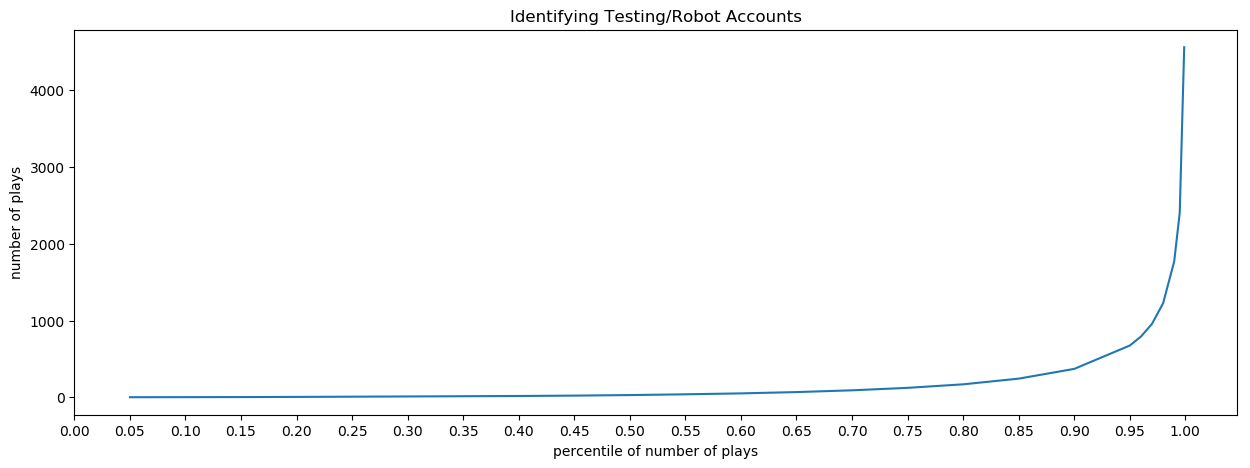

In [156]:
plt.clf()
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(p_df['percentile'], p_df['num_plays'])
ax.set_xlabel('percentile of number of plays')
ax.set_ylabel('number of plays') 
ax.set_xticks(np.arange(0,1.05, 0.05))
ax.set_title('Identifying Testing/Robot Accounts')
plt.show()


In [104]:
all_uid_count.repartition(1).write.csv('../Data/all_uid_count', header=True)

In [ ]:
all_uid_count = spark.read.csv('../Data/all_uid_count.csv', header=True)

- ***Finding 1: Obviously some uid are testing accounts (i.e. robots) and should be excluded from the sample***

## 3.2 Check for abnormal play_time, song_length

In [ ]:
song_df.select('play_time', 'song_length', 'paid_flag').describe().show()

In [12]:
song_df_2 = song_df.withColumn("device", trim(song_df.device)) \
                               .withColumn('date_str', trim(song_df.file_name.substr(1,9))) \
                               .withColumn('date_string', regexp_replace('date_str', '20170339', '20170329')) \
                               .withColumn("unix_date", unix_timestamp('date_string', 'yyyyMMdd')) \
                               .withColumn("date", from_unixtime('unix_date').cast(DateType())) \
                               .drop('date_str') \
                               .drop('date_string') \
                               .drop('unix_date') \
                               .drop('paid_flag') \
                               .drop('song_name') \
                               .drop('singer') \
                               .dropna(how='any', subset=['play_time']) 

In [308]:
pd.DataFrame(song_df_2.take(5), columns=song_df_2.columns)

,uid,device,song_id,song_type,play_time,song_length,file_name,date
0,154422682,ar,20870992.0,1.0,22013.0,332.0,20170301_play.log,2017-03-01
1,154421907,ip,6560858.0,0.0,96.0,161.0,20170301_play.log,2017-03-01
2,154422630,ar,3385963.0,1.0,235868.0,235.0,20170301_play.log,2017-03-01
3,154410267,ar,6777172.0,0.0,164.0,237.0,20170301_play.log,2017-03-01
4,154407793,ar,19472464.0,0.0,24.0,201.0,20170301_play.log,2017-03-01


***Finding 2: I noticed play log files are missing from 20170310 to 20170328, download log and search log start from 20170330, and therefore I only use play logs from 20170330***

***Finding 3: play_time and song_length may be recorded in milli-seconds as opposed to seconds in some records. Judging from limited records, play_time in milli-seconds seem to relate to song_time = 1  ***

In [13]:
song_df_3 = song_df_2.drop('file_name') \
                     .filter(song_df_2.date>='2017-03-30') \
                     .filter(song_df_2.song_length > 0) \
                     .filter(song_df_2.song_length < 10E6) \
                     .filter(song_df_2.play_time >= 0) \
                     .filter(song_df_2.play_time<10E6)
               

In [310]:
pd.DataFrame(song_df_3.take(5), columns=song_df_3.columns)

,uid,device,song_id,song_type,play_time,song_length,date
0,168550892,ar,23491656.0,0.0,254.0,254.0,2017-03-30
1,168540455,ar,298250.0,0.0,189.0,190.0,2017-03-30
2,168551247,ar,11881432.0,0.0,78.0,149.0,2017-03-30
3,168549788,ip,295469.0,0.0,16.0,242.0,2017-03-30
4,168551248,ip,21393368.0,0.0,87.0,87.0,2017-03-30


In [ ]:
# test my hypothesis that song_type is related to play_time recorded in milli-seconds
song_df_3.sample(False, 0.00001, seed=0) \
         .groupBy('song_type') \
         .agg({'play_time': 'avg', \
               'song_length':'avg' }) \
         .show()

In [ ]:
song_df_3.sample(False, 0.00001, seed=0).groupBy('song_type').agg({'play_time': "max"}).show()

In [119]:
song_df_4 = song_df_3.withColumn('play_time_adj', \
                                 when(song_df_3.play_time > 10E3, song_df_3.play_time/1000) \
                                 .otherwise(song_df_3.play_time)) \
                     .withColumn('song_length_adj', \
                                 when(song_df_3.song_length > 10E3, song_df_3.song_length/1000) \
                                 .otherwise(song_df_3.song_length))
                    

In [ ]:
song_df_4.sample(False, 0.00001, seed=0).groupBy('song_type').agg({'play_time': "max", "uid":"count"}).show()

In [120]:
song_df_5 = song_df_4.drop('play_time') \
                     .drop('song_length') \
                     .withColumnRenamed('play_time_adj', 'play_time') \
                     .withColumnRenamed('song_length_adj', 'song_length')

In [121]:
song_df_5.persist(MEMORY_AND_DISK_SER)

DataFrame[uid: string, device: string, song_id: float, song_type: float, date: date, play_time: double, song_length: double]

In [122]:
song_df_5.schema

StructType(List(StructField(uid,StringType,false),StructField(device,StringType,true),StructField(song_id,FloatType,false),StructField(song_type,FloatType,true),StructField(date,DateType,true),StructField(play_time,DoubleType,true),StructField(song_length,DoubleType,true)))

In [123]:
pd.DataFrame(song_df_5.take(5), columns=song_df_5.columns)

,uid,device,song_id,song_type,date,play_time,song_length
0,168550892,ar,23491656.0,0.0,2017-03-30,254.0,254.0
1,168540455,ar,298250.0,0.0,2017-03-30,189.0,190.0
2,168551247,ar,11881432.0,0.0,2017-03-30,78.0,149.0
3,168549788,ip,295469.0,0.0,2017-03-30,16.0,242.0
4,168551248,ip,21393368.0,0.0,2017-03-30,87.0,87.0


- ***song_df_5 is the data with cleaned up "play_time" and "song_length"***

In [ ]:
# Results from previous sanity check. Takes too long to run... 
# song_df.select('play_time', 'song_length', 'paid_flag').describe().show()

## Step 3.1  Remove robots (those above 99.5 percentile), save valid_uid to ../Data/valid_uid.csv. Merge song_df_5 with valid_uid

In [ ]:
# calculate percentile in spark is very slow. Much faster in excel...
# count_ceiling = uid_count.approxQuantile("count", [0.95], 0)

In [157]:
valid_uid = all_uid_count.filter(all_uid_count['count'] <= 2406)

In [158]:
valid_uid.repartition(1).write.csv('../Data/valid_uid', header=True)
# in case session is terminated, to save time, just read from csv to load the DataFrame
# active_uid = spark.read.csv('../Data/active_uid.csv')
# valid_uid = spark.read.csv('../Data/valid_uid.csv')

In [33]:
schema_id = StructType([StructField('uid', StringType(), False),
                        StructField('count', IntegerType(), True)])

valid_uid = spark.read.csv('../Data/valid_uid.csv', schema=schema_id, header=True)

In [162]:
valid_uid.schema

StructType(List(StructField(uid,StringType,false),StructField(count,LongType,false)))

In [165]:
song_df_valid = song_df_5.join(valid_uid, song_df_5.uid == valid_uid.uid, how='inner') \
                         .drop(song_df_5.uid) \
                         .persist(storageLevel=MEMORY_AND_DISK_SER)
               

In [ ]:
pd.DataFrame(song_df_valid.take(5), columns=song_df_valid.columns)

# Step 4. Create Churn Label on Distinct Account Level

In [ ]:
# valid play log dated from 20170329 to 20170512, 
# use last 2 week as churn window 
active_uid = song_df_valid.filter(song_df_valid.date > '2017-04-29') \
                          .select(song_df_valid.uid.alias('active_uid')) \
                          .distinct()

active_uid.repartition(1).write.csv('../Data/active_uid', header=True)                                             

In [51]:
active_uid = spark.read.csv('../Data/active_uid.csv', header=True)
active_uid.schema

StructType(List(StructField(active_uid,StringType,true)))

In [52]:
# on valid_uid, active_uid are both 1 row for each account
uid_label = valid_uid.select('valid_uid') \
                     .join(active_uid, valid_uid.valid_uid == active_uid.active_uid, 'left_outer') 

In [53]:
uid_label = uid_label.withColumn('churn', uid_label.active_uid.isNull().astype(IntegerType())) \
                     .cache()

In [68]:
uid_label.schema

StructType(List(StructField(valid_uid,StringType,true),StructField(active_uid,StringType,true),StructField(churn,IntegerType,false)))

In [ ]:
# sanity check
pd.DataFrame(uid_label.take(5), columns=uid_label.columns)

In [ ]:
# write output to csv, share with team members
uid_label.select('uid', 'churn').repartition(1).write.csv('../Data/uid_label', header=True)

# Step 5. Downsample such that churn categories (0, 1) weigh equally

In [54]:
uid_label.groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|51541|
|    0|83885|
+-----+-----+



In [65]:
print("total number of account is: {0:,}".format(51541+83885))

total number of account is: 135,426


In [60]:
ratio = 51541/83885
print("churn vs not churn is {0:%}".format(ratio))

churn vs not churn is 61.442451%


In [91]:
sampled_uid = uid_label.drop('active_uid').sampleBy('churn', fractions={1:0.01, 0:0.006}, seed=0)
# sampled_uid.groupBy('churn').count().show()

In [92]:
sampled_uid.cache()
sampled_uid.schema

StructType(List(StructField(valid_uid,StringType,true),StructField(churn,IntegerType,false)))

# Step 6. Read logs (Play, Search, Download) that are in the sample selected 

In [98]:
play_sample.unpersist()

DataFrame[uid: float, device: string, song_id: float, song_type: float, date: date, play_time: double, song_length: double, churn: int]

In [99]:
play_sample = song_df_valid.drop('valid_uid') \
                           .drop('count') \
                           .filter(song_df_valid.date < '2017-04-29') \
                           .filter(song_df_valid.date > '2017-03-29') \
                           .join(sampled_uid, sampled_uid.valid_uid == song_df_valid.uid, 'inner') \
                           .drop(sampled_uid.valid_uid) \
                           .persist(MEMORY_AND_DISK_SER)

In [100]:
play_sample.count()

386875

In [101]:
# write to csv for future direct load-in
play_sample.repartition(1).write.csv('../Data/play_sample', header=True)

In [56]:
play_sample = spark.read.csv('../Data/play_sample.csv', header=True)
play_sample.schema

StructType(List(StructField(uid,StringType,true),StructField(device,StringType,true),StructField(song_id,StringType,true),StructField(song_type,StringType,true),StructField(date,StringType,true),StructField(play_time,StringType,true),StructField(song_length,StringType,true),StructField(churn,StringType,true)))

In [57]:
pd.DataFrame(play_sample.take(10), columns=play_sample.columns)

,uid,device,song_id,song_type,date,play_time,song_length,churn
0,1.67861376E8,ip,5728245.0,0.0,2017-03-31,39.0,39.0,0
1,1.67861376E8,ip,492209.0,0.0,2017-03-31,127.0,272.0,0
2,1.67861376E8,ip,3418611.0,0.0,2017-03-31,1.0,233.0,0
3,1.67861376E8,ip,3226009.0,0.0,2017-03-31,0.0,257.0,0
4,1.67861376E8,ip,4963794.0,0.0,2017-03-31,0.0,220.0,0
5,1.67861376E8,ip,3351562.0,0.0,2017-03-31,0.0,238.0,0
6,1.67861376E8,ip,2.2797708E7,0.0,2017-03-31,0.0,229.0,0
7,1.67861376E8,ip,4140214.0,0.0,2017-03-31,14.0,14.0,0
8,1.67861376E8,ip,492209.0,0.0,2017-03-31,2.0,272.0,0
9,1.67861376E8,ip,4388183.0,0.0,2017-03-31,0.0,3.0,0


In [75]:
play_sample.dtypes

[('uid', 'string'),
 ('device', 'string'),
 ('song_id', 'string'),
 ('song_type', 'string'),
 ('date', 'string'),
 ('play_time', 'string'),
 ('song_length', 'string'),
 ('churn', 'string')]

# Step 7. Read Download & Search Data 

In [152]:
rdd_down = sc.textFile(name="../Data/all_download.log.fn")
# schema = ['uid','device','song_id','song_name','singer','paid_flag']

In [ ]:
rdd_down.take(2)

In [163]:
def parseLineDown(line):
    fields = line.split("\t")
    if len(fields) == 7:
        try: 
            uid = str(fields[0])
            song_id = str(fields[2])
            song_name = str(fields[3])
            file_name = str(fields[6])
            return Row(uid, song_id, song_name, file_name)
        except:
            return -1
    else:
        return -1

In [164]:
schema_down = StructType([StructField('uid', StringType(), False),
                          StructField('song_id_down', StringType(), False),
                          StructField('song_name_down', StringType(), False),
                          StructField('file_name', StringType(), True),])

In [165]:
len(schema_down)

4

In [166]:
# Parse download log 
down = rdd_down.map(parseLineDown).filter(lambda x: x!=-1)

In [ ]:
down_df = spark.createDataFrame(down, schema_down)
pd.DataFrame(down_df.take(5), columns=down_df.columns)

In [169]:
down_df_2 = down_df.withColumn('date_str', trim(down_df.file_name.substr(1,9))) \
                   .withColumn("unix_date", unix_timestamp('date_str', 'yyyyMMdd')) \
                   .withColumn("date_down", from_unixtime('unix_date').cast(DateType())) \
                   .drop('date_str') \
                   .drop('unix_date') \
                   .drop('file_name') \
                   .dropna(how='any', subset=['song_id_down']) 

In [170]:
pd.DataFrame(down_df_2.take(5), columns=down_df_2.columns)

,uid,song_id_down,song_name_down,date_down
0,168019808.0,442554.0,小酒窝,2017-03-30
1,168019808.0,6334611.0,社会摇,2017-03-30
2,168019808.0,9867382.0,台阶,2017-03-30
3,168019808.0,6660691.0,一次就好-(电影《夏洛特烦恼》暖水曲),2017-03-30
4,168019808.0,157606.0,一路上有你,2017-03-30


In [171]:
# write download log of all dates to csv, for future usage
down_df_2.repartition(1).write.csv('../Data/down', header=True)

In [68]:
down_all = spark.read.csv('../Data/download_all.csv', header=True)

In [85]:
down_all.show()

+------------+------------+--------------------+----------+
|         uid|song_id_down|      song_name_down| date_down|
+------------+------------+--------------------+----------+
|1.68019808E8|    442554.0|                 小酒窝|2017-03-30|
|1.68019808E8|   6334611.0|                 社会摇|2017-03-30|
|1.68019808E8|   9867382.0|                  台阶|2017-03-30|
|1.68019808E8|   6660691.0| 一次就好-(电影《夏洛特烦恼》暖水曲)|2017-03-30|
|1.68019808E8|    157606.0|               一路上有你|2017-03-30|
|1.68019808E8|   3372481.0|        十年 (OT：明年今日)|2017-03-30|
|1.68019808E8|   3216525.0|       你不知道的事(Live版)|2017-03-30|
|1.68019808E8|   6427523.0|             Victory|2017-03-30|
|1.68019808E8|   6538686.0|                  野子|2017-03-30|
|1.68019808E8|   9327383.0|なんでもないや-[没什么大不了](...|2017-03-30|
|1.68019808E8|   6716077.0|我们不该这样的-(电视剧《北上广不...|2017-03-30|
|1.68019808E8|    350052.0|                爱情转移|2017-03-30|
|1.68019808E8|   3638735.0|               咱们结婚吧|2017-03-30|
|1.68019808E8|    409466.0|        Alway

In [69]:
down_all.dtypes

[('uid', 'string'),
 ('song_id_down', 'string'),
 ('song_name_down', 'string'),
 ('date_down', 'string')]

# Repeat All Steps Above for Search Log

In [50]:
rdd_search = sc.textFile(name="../Data/all_search.log.fn")
rdd_search.take(5)

['nohup: ignoring input \t 20170330_1_search.log',
 '168050208 \tar \t2017-03-30 00:00:00 \t%E5%87%A4%E5%87%B0%E4%BC%A0%E5%A5%87 \t 20170330_1_search.log',
 '167659521 \tar \t2017-03-30 00:00:01 \t%E5%B0%8F%E6%B4%B2 \t 20170330_1_search.log',
 '168411725 \tip \t2017-03-30 00:00:01 \t%e5%ae%b9%e4%b8%ad%e5%b0%94%e7%94%b2%20%20%e9%ab%98%e5%8e%9f%e7%ba%a2 \t 20170330_1_search.log',
 '167852824 \tar \t2017-03-30 00:00:02 \t%E9%83%BD%E6%98%AF%E5%85%84%E5%BC%9F \t 20170330_1_search.log']

In [51]:
def parseLineSearch(line):
    fields = line.split("\t")
    if len(fields) == 5:
        try:
            uid = float(fields[0])
            date_str = str(fields[2])
            search_query = str(fields[3])
            return Row(uid, date_str, search_query)
        
        except:
            return -1
    else:
            return -1

In [52]:
schema_search = StructType([StructField('uid', FloatType(), False),
                            StructField('search_date_str', StringType(), False),
                            StructField('search_query', StringType(), False)])

In [53]:
search = rdd_search.map(parseLineSearch).filter(lambda x: x!=-1).filter(lambda x: len(x) == len(schema_search))

In [54]:
search_df = spark.createDataFrame(search, schema_search).dropna()

In [64]:
pd.DataFrame(search_df.take(5), columns=search_df.columns)

,uid,search_date_str,search_query
0,168050208.0,2017-03-30 00:00:00,%E5%87%A4%E5%87%B0%E4%BC%A0%E5%A5%87
1,167659520.0,2017-03-30 00:00:01,%E5%B0%8F%E6%B4%B2
2,168411728.0,2017-03-30 00:00:01,%e5%ae%b9%e4%b8%ad%e5%b0%94%e7%94%b2%20%20%e9%...
3,167852832.0,2017-03-30 00:00:02,%E9%83%BD%E6%98%AF%E5%85%84%E5%BC%9F
4,168043776.0,2017-03-30 00:00:02,%E8%91%AB%E8%8A%A6%E4%B8%9D


In [63]:
search_df.repartition(1).write.csv("../Data/search_all", header=True)

In [66]:
search_all = spark.read.csv("../Data/search_all.csv", header=True)

In [67]:
search_all.dtypes

[('uid', 'string'), ('search_date_str', 'string'), ('search_query', 'string')]

# Step 8. Merge search_all and down_all against play_sample

In [76]:
sample_id = play_sample.select('uid').distinct()

In [77]:
sample_id.repartition(1).write.csv('../Data/sample_id', header=True)

In [81]:
sample_id.count()

691

In [92]:
down_sample = sample_id.join(down_all, sample_id.uid == down_all.uid, 'inner') \
                       .drop(down_all.uid) \
                       .dropna(how='any', subset=['date_down', 'song_id_down']) 
        
        
down_sample.repartition(1).write.csv('../Data/download_sample', header=True)

In [93]:
down_sample = spark.read.csv('../Data/download_sample.csv', header=True)

In [94]:
down_sample.show()

+-----------+------------+---------------+----------+
|        uid|song_id_down| song_name_down| date_down|
+-----------+------------+---------------+----------+
|1.6804656E8|     93305.0|      真心至上(完整版)|2017-03-30|
|1.6804656E8| 2.2830568E7|2017社会鼓 (Remix)|2017-03-30|
|1.6804656E8|  2.349608E7|              路|2017-03-30|
|1.6804656E8| 2.3037352E7|         现实社会之混|2017-03-30|
|1.6804656E8| 2.3288484E7|              肉|2017-03-30|
|1.6804656E8| 2.0275342E7|         皮皮虾我们走|2017-03-30|
|1.6804656E8| 2.0873728E7|           大话西游|2017-03-30|
|1.6804656E8|   6989312.0|       三生三世十里桃花|2017-03-30|
|1.6804656E8| 2.0671304E7|             人心|2017-03-30|
|1.6804656E8|   6692062.0|        乱世烽火出英雄|2017-03-30|
|1.6804656E8|   9932335.0|        何必执着一张脸|2017-03-30|
|1.6804656E8|   5376245.0|          起伏的日子|2017-03-30|
|1.6804656E8|   9868920.0|        她只喝酒不说话|2017-03-30|
|1.6804656E8|   9930485.0|         姑娘 你怂了|2017-03-30|
|1.6804656E8|   7105507.0|    你照顾好他.我四海为家|2017-03-30|
|1.6804656E8|   9862302.0|  

In [98]:
search_sample = sample_id.join(search_all, sample_id.uid == search_all.uid, 'inner') \
                         .drop(search_all.uid) \
                         .dropna('any', subset=['uid', 'search_date_str', 'search_query'])
                    

In [99]:
search_sample.repartition(1).write.csv('../Data/search_sample', header=True)

# END

In [147]:
def compute_freq(df, event_type, window, end_date):
    df_win = df.filter(date_add(play_sample.date, window) < end_date)
    df_feature = df_win.groupBy('uid').agg(count('uid').alias('freq_' + event_type + '_last_' + str(window) + 'days'))
    
    return df_feature

In [148]:
play_1 = compute_freq(play_sample, event_type, window, end_date)

In [150]:
play_1.show(5)

+------------+--------------------+
|         uid|freq_play_last_3days|
+------------+--------------------+
|1.67861376E8|                 817|
|1.68017424E8|                 557|
|1.68273328E8|                 236|
|1.68466368E8|                 119|
|1.68889152E8|                 380|
+------------+--------------------+
only showing top 5 rows



In [ ]:
for i in [1,3,7,14,30]:
    play

In [119]:
df = play_sample.filter(date_add(play_sample.date, 3) < end_date)

In [126]:
out = df.groupBy('uid').agg(count('uid').alias('freq_' + event_type + '_last_' + str(window) + 'days'))

In [128]:
out.show(10)

+------------+--------------------+
|         uid|freq_play_last_3days|
+------------+--------------------+
|1.67861376E8|                 817|
|1.68017424E8|                 557|
|1.68273328E8|                 236|
|1.68466368E8|                 119|
|1.68889152E8|                 380|
| 1.6773736E8|                 107|
|1.67869824E8|                 820|
|1.58661728E8|                   1|
| 1.6776896E8|                1804|
|1.68072944E8|                 585|
+------------+--------------------+
only showing top 10 rows



In [144]:
df.select(df.date).groupBy().min('date').show()

AnalysisException: '"date" is not a numeric column. Aggregation function can only be applied on a numeric column.;'

In [ ]:
play_sample.select('play_time', 'song_length').describe().show()

In [ ]:
play_sample.groupBy('date').count().orderBy('date').show(90)

In [ ]:
pd.DataFrame(play_sample.take(5), columns = play_sample.columns)

In [ ]:
play_sample.crosstab('churn', 'device').show()
# !! Finding: device field is not clean, needs trimming 

#### churn - 14% use iphone
#### not churn - 17% use iphone

In [ ]:
uid_set = set(sampled_uid.select('uid'))
with open("../Data/all_play_log.log.fn") as infile:
    for line in infile:
        if line.splint('\t')

### Convert RDD to DataFrame, from YouTube Video:
https://www.youtube.com/watch?v=dzYEWULDIAQ&list=PLE50-dh6JzC5zo2whIGqJ02CIhP3ysQLX&index=5

In [ ]:
# map RDD to a DataFrame
# important to filter away lines that do not contain 10 elements
# otherwise, get "Index out of range error"

df = rdd.map(lambda line: line.split("\t")).filter(lambda line: len(line) == 10)
df = (df.map(lambda line: Row(uid = line[0], 
                             device = line[1], 
                             song_id = line[2], 
                             song_type = line[3], 
                             singer = line[5], 
                             play_time = line[6], 
                             song_length = line[7], 
                             paid_flag = line[8], 
                             file_name = line[9]))
      .toDF())

In [ ]:
df.columns

In [ ]:
df.show(10)

In [ ]:
df.describe().show()